In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from shapely.geometry import Point
from datetime import timedelta
from pymeos import *

import geopandas as gpd
import movingpandas as mpd
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

pymeos_initialize()

In [29]:
def create_point(row):
    return TGeogPointInst(string=f"{row['geometry']}@{row.name}")


def extract_wkt_from_traj(trajectory):
    res = "["
    for row in trajectory.df.iloc():
        res += f'{row.geometry.wkt}@{row.name},'
    res = res[:-1] + ']'
    return res

def create_sequence(trajectory):
    wkt = extract_wkt_from_traj(trajectory)
    return TGeogPointSeq(string=wkt)

In [30]:
def create_model(x, dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=x.shape[-2:]),
        tf.keras.layers.LSTM(32, return_sequences=True, ),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(dim)
    ])
    return model

def create_sequences(data, sequence_length=10, prediction_steps=3):
    X, y = [], []
    data = data.sort_index()  # Ensure the data is sorted by time
    for mmsi in data['mmsi'].unique():
        mmsi_data = data[data['mmsi'] == mmsi][['sog', 'lat', 'lon']]
        for i in range(len(mmsi_data) - sequence_length - prediction_steps + 1):
            X.append(mmsi_data.iloc[i:i+sequence_length].values)
            y.append(mmsi_data.iloc[i+sequence_length:i+sequence_length+prediction_steps][['lat', 'lon']].values)
    return np.array(X), np.array(y)

In [31]:
pdf = pd.read_csv('./data/aisinput.csv')
pdf.head()

,t,mmsi,latitude,longitude,sog
0,2021-01-08 00:00:00,265513270,57.05900,12.272388,0.0
1,2021-01-08 00:00:01,219027804,55.94244,11.866278,0.0
2,2021-01-08 00:00:01,265513270,57.05900,12.272388,0.0
3,2021-01-08 00:00:03,219027804,55.94244,11.866278,0.0
4,2021-01-08 00:00:04,265513270,57.05900,12.272388,0.0


In [32]:
gdf = gpd.GeoDataFrame(pdf.drop(['latitude', 'longitude'], axis=1),
                       geometry=gpd.points_from_xy(pdf.longitude, pdf.latitude), crs=4326)
gdf.head()

,t,mmsi,sog,geometry
0,2021-01-08 00:00:00,265513270,0.0,POINT (12.27239 57.05900)
1,2021-01-08 00:00:01,219027804,0.0,POINT (11.86628 55.94244)
2,2021-01-08 00:00:01,265513270,0.0,POINT (12.27239 57.05900)
3,2021-01-08 00:00:03,219027804,0.0,POINT (11.86628 55.94244)
4,2021-01-08 00:00:04,265513270,0.0,POINT (12.27239 57.05900)


In [33]:
ships = mpd.TrajectoryCollection(gdf, 'mmsi', t='t')

In [34]:
ship = ships.trajectories[1]
shipdf = ship.df
shipdf.head(10)

,mmsi,sog,geometry
t,,,
2021-01-08 00:00:01,219027804,0.0,POINT (11.86628 55.94244)
2021-01-08 00:00:03,219027804,0.0,POINT (11.86628 55.94244)
2021-01-08 00:00:05,219027804,0.0,POINT (11.86628 55.94244)
2021-01-08 00:00:07,219027804,0.0,POINT (11.86628 55.94244)
2021-01-08 00:00:09,219027804,0.0,POINT (11.86628 55.94244)
2021-01-08 00:00:11,219027804,0.0,POINT (11.86628 55.94244)
2021-01-08 00:00:13,219027804,0.0,POINT (11.86628 55.94244)
2021-01-08 00:00:15,219027804,0.0,POINT (11.86628 55.94244)
2021-01-08 00:00:16,219027804,0.0,POINT (11.86628 55.94245)


In [69]:
testdf = shipdf.copy()
testdf['lon'] = testdf['geometry'].x
testdf['lat'] = testdf['geometry'].y

scaler_test = MinMaxScaler()

testdf[['lat', 'lon']] = scaler_test.fit_transform(testdf[['lat', 'lon']])
testdf = testdf[['sog', 'lat', 'lon']]

sequence_length = 100  # Number of steps in input sequences
prediction_steps = 10 

X_act = np.array([testdf.iloc[30000:30100].values])
y_act = np.array([testdf.iloc[30100:30110][['lat', 'lon']].values])

comparison = {"name": [], "time": [], "RMSE": []}

In [70]:
import time

comparison["name"].append("MovingPandas")
timestr = ""

scaler = MinMaxScaler()

data =  shipdf.copy()
data = data.iloc[:20000]
data['lon'] = shipdf['geometry'].x
data['lat'] = shipdf['geometry'].y

start = time.time()
data[['lat', 'lon']] = scaler.fit_transform(data[['lat', 'lon']])

sequence_length = 100  # Number of steps in input sequences
prediction_steps = 10  # Steps to predict ahead

X, y = create_sequences(data, sequence_length, prediction_steps)
end = time.time() - start
timestr += f'Processing Time: {end} seconds'

# Split data into training and testing sets based on the first 80% for training and the last 20% for testing
# num_sequences = len(X)
# train_size = int(num_sequences * 0.80)

# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# Split data into training and testing sets
# Define your train_test_split logic here

# Prepare and train the model
start = time.time()
model = create_model(X, y.shape[-1] * y.shape[-2])  # Adjust 'dim' based on prediction shape
model.compile(optimizer='adam', loss='mse')

# Note: You might need to reshape 'y' depending on how you structure your network's output layer
y = y.reshape(y.shape[0], -1)  # Flatten y if necessary for the Dense output layer

model.fit(X, y, epochs=3, validation_split=0.2)
end = time.time() - start
timestr += f' Training Time: {end} seconds'

comparison["time"].append(timestr)

Epoch 1/3
498/498 [==============================] - 25s 45ms/step - loss: 0.0180 - val_loss: 0.0483
Epoch 2/3
498/498 [==============================] - 22s 45ms/step - loss: 9.3214e-08 - val_loss: 0.0483
Epoch 3/3
498/498 [==============================] - 22s 44ms/step - loss: 9.5073e-08 - val_loss: 0.0483


1/1 [==============================] - 1s 554ms/step


/home/satria/miniconda3/envs/thesis/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(
/home/satria/miniconda3/envs/thesis/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(


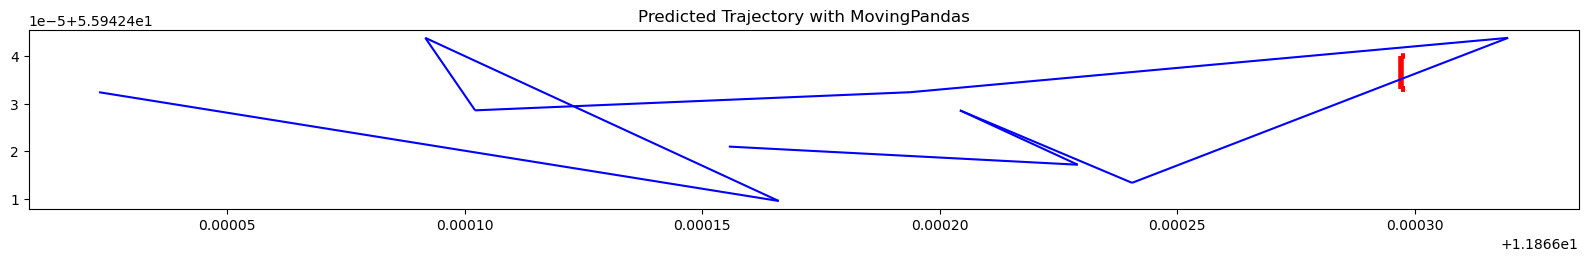

In [72]:
# Prediction
y_pred_scaled = model.predict(X_act)

y_pred = y_pred_scaled.reshape(-1, prediction_steps, 2)  # Reshape predictions
y_pred_2d = y_pred.reshape(-1, y_pred.shape[-1])
result_2d = scaler.inverse_transform(y_pred_2d)
y_pred_inv = result_2d.reshape(y_pred.shape)


# #test
y_test_scaled = y_act.reshape(-1, prediction_steps, 2)  # Reshape predictions
y_test_2d = y_test_scaled.reshape(-1, y_test_scaled.shape[-1])
res_test_2d = scaler_test.inverse_transform(y_test_2d)
y_test_inv = res_test_2d.reshape(y_test_scaled.shape)

# Visualization with MovingPandas
predicted_points = [Point(long, lat) for lat, long in y_pred_inv[0]]
actual_points = [Point(long, lat) for lat, long in y_test_inv[0]]

predicted_gdf = gpd.GeoDataFrame(geometry=predicted_points)
actual_gdf = gpd.GeoDataFrame(geometry=actual_points)

# # # Create a simple time index with the desired format
start_time_str = '2021-01-08 00:00:00'
start_time = pd.to_datetime(start_time_str, format='%Y-%m-%d %H:%M:%S')

time_step_seconds = 3  # Adjust the time step as needed
predicted_gdf['t'] = [start_time + pd.Timedelta(seconds=i * time_step_seconds) for i in range(len(predicted_gdf))]
predicted_gdf.set_index('t', inplace=True)

actual_gdf['t'] = [start_time + pd.Timedelta(seconds=i * time_step_seconds) for i in range(len(actual_gdf))]
actual_gdf.set_index('t', inplace=True)

trajectory = mpd.Trajectory(predicted_gdf, 't')
actual_trajectory = mpd.Trajectory(actual_gdf, 't')

# # Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 20))
actual_trajectory.plot(ax=ax, linewidth=4, color='red')
trajectory.plot(ax=ax, linewidth=1.5, color='blue')

plt.title('Predicted Trajectory with MovingPandas')
plt.show()

# # # Calculate RMSE for latitude and longitude only
rmse_lat = np.sqrt(mean_squared_error(y_test_inv[:, :, 0], y_pred_inv[:, :, 0]))
rmse_lon = np.sqrt(mean_squared_error(y_test_inv[:, :, 1], y_pred_inv[:, :, 1]))
comparison["RMSE"].append(f"RMSE for Latitude: {rmse_lat}, RMSE for Longitude: {rmse_lon}")

In [73]:
print(np.sqrt(mean_squared_error(y_test_inv[:, 9, 0], y_pred_inv[:, 9, 0])) ,np.sqrt(mean_squared_error(y_test_inv[:, 9, 1], y_pred_inv[:, 9, 1])))

5.964355480614358e-07 0.00027393634033145986


In [55]:
actual_gdf

,geometry
t,
2021-01-08 00:00:00,POINT (11.86630 55.94244)
2021-01-08 00:00:03,POINT (11.86630 55.94244)
2021-01-08 00:00:06,POINT (11.86630 55.94244)
2021-01-08 00:00:09,POINT (11.86630 55.94244)
2021-01-08 00:00:12,POINT (11.86630 55.94243)
2021-01-08 00:00:15,POINT (11.86630 55.94243)
2021-01-08 00:00:18,POINT (11.86630 55.94243)
2021-01-08 00:00:21,POINT (11.86630 55.94243)
2021-01-08 00:00:24,POINT (11.86630 55.94243)


In [74]:
ship.add_speed(overwrite=True)
ship.add_distance(overwrite=True)

meosdf = ship.df.copy()
meosdf = meosdf.iloc[:20000]

In [75]:
meosdf['MEOS Point'] = meosdf.apply(create_point, axis=1)
meosdf.head()

,mmsi,sog,geometry,speed,distance,MEOS Point
t,,,,,,
2021-01-08 00:00:01,219027804,0.0,POINT (11.86628 55.94244),0.000000,0.000000,POINT(11.866278 55.94244)@2021-01-08 00:00:01+01
2021-01-08 00:00:03,219027804,0.0,POINT (11.86628 55.94244),0.000000,0.000000,POINT(11.866278 55.94244)@2021-01-08 00:00:03+01
2021-01-08 00:00:05,219027804,0.0,POINT (11.86628 55.94244),0.000000,0.000000,POINT(11.866278 55.94244)@2021-01-08 00:00:05+01
2021-01-08 00:00:07,219027804,0.0,POINT (11.86628 55.94244),0.062485,0.124971,POINT(11.86628 55.94244)@2021-01-08 00:00:07+01
2021-01-08 00:00:09,219027804,0.0,POINT (11.86628 55.94244),0.000000,0.000000,POINT(11.86628 55.94244)@2021-01-08 00:00:09+01


In [76]:
sum(meosdf[ship.distance_col_name])

19141.909882682434

In [77]:
sequence = TGeogPointSeq(instant_list=list(meosdf['MEOS Point']), normalize=False)
sequence.length()

19141.909882991968

In [78]:
sequence = TGeogPointSeq(instant_list=list(meosdf['MEOS Point']), normalize=True)
sequence.length()

19117.91257397039

In [79]:
sequence.num_instants()

7621

In [80]:
len(meosdf)

20000

In [81]:
datameos = sequence.to_dataframe()
datameos.head()

,value
time,
2021-01-08 00:00:01+01:00,POINT (11.866278 55.94244)
2021-01-08 00:00:05+01:00,POINT (11.866278 55.94244)
2021-01-08 00:00:09+01:00,POINT (11.86628 55.94244)
2021-01-08 00:00:11+01:00,POINT (11.866278 55.94244)
2021-01-08 00:00:15+01:00,POINT (11.86628 55.94244)


In [82]:
def create_sequences_meos(data, sequence_length=10, prediction_steps=3):
    X, y = [], []
    data = data.sort_index()  # Ensure the data is sorted by time
    mmsi_data = data[['lat', 'lon']]
    for i in range(len(mmsi_data) - sequence_length - prediction_steps + 1):
        X.append(mmsi_data.iloc[i:i+sequence_length].values)
        y.append(mmsi_data.iloc[i+sequence_length:i+sequence_length+prediction_steps][['lat', 'lon']].values)
    return np.array(X), np.array(y)

In [83]:
import time

comparison["name"].append("PyMeos")
timestr = ""

scaler = MinMaxScaler()
      
datameos['lon'] = datameos['value'].apply(lambda val: val.x)
datameos['lat'] = datameos['value'].apply(lambda val: val.y)

start = time.time()
datameos[['lat', 'lon']] = scaler.fit_transform(datameos[['lat', 'lon']])

sequence_length = 100  # Number of steps in input sequences
prediction_steps = 10  # Steps to predict ahead

X, y = create_sequences_meos(datameos, sequence_length, prediction_steps)
end = time.time() - start
timestr += f'Processing Time: {end} seconds'

# Split data into training and testing sets based on the first 80% for training and the last 20% for testing
# num_sequences = len(X)
# train_size = int(num_sequences * 0.80)

# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# Split data into training and testing sets
# Define your train_test_split logic here

# Prepare and train the model
start = time.time()
model = create_model(X, y.shape[-1] * y.shape[-2])  # Adjust 'dim' based on prediction shape
model.compile(optimizer='adam', loss='mse')

# Note: You might need to reshape 'y' depending on how you structure your network's output layer
y = y.reshape(y.shape[0], -1)  # Flatten y if necessary for the Dense output layer

model.fit(X, y, epochs=3, validation_split=0.2)
end = time.time() - start
timestr += f' Training Time: {end} seconds'

comparison["time"].append(timestr)

Epoch 1/3
188/188 [==============================] - 12s 50ms/step - loss: 0.0817 - val_loss: 0.0591
Epoch 2/3
188/188 [==============================] - 8s 44ms/step - loss: 0.0177 - val_loss: 0.0585
Epoch 3/3
188/188 [==============================] - 8s 44ms/step - loss: 0.0260 - val_loss: 0.0857


1/1 [==============================] - 1s 536ms/step


/home/satria/miniconda3/envs/thesis/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(
/home/satria/miniconda3/envs/thesis/lib/python3.11/site-packages/movingpandas/trajectory.py:166: MissingCRSWarning: Trajectory generated without CRS. Computations will use Euclidean distances.
  warnings.warn(


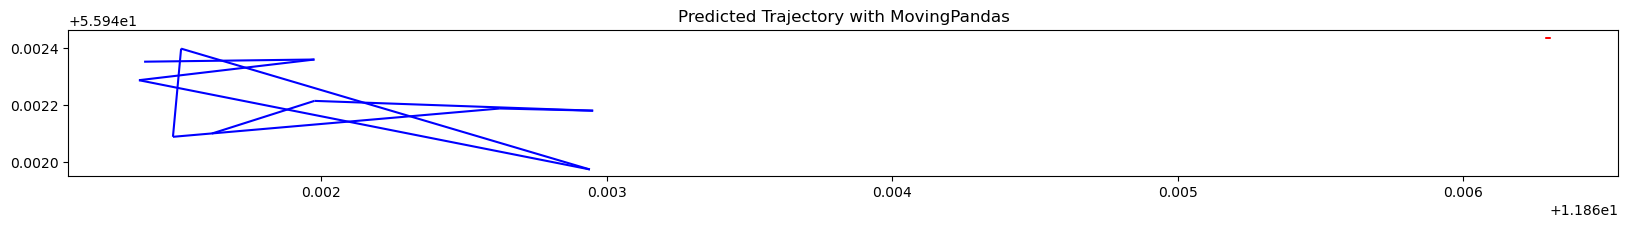

In [84]:
# Prediction
X_act_meos = X_act[:, :, 1:]
y_pred_scaled = model.predict(X_act_meos)

y_pred = y_pred_scaled.reshape(-1, prediction_steps, 2)  # Reshape predictions
y_pred_2d = y_pred.reshape(-1, y_pred.shape[-1])
result_2d = scaler.inverse_transform(y_pred_2d)
y_pred_inv = result_2d.reshape(y_pred.shape)


# # #test
y_test_scaled = y_act.reshape(-1, prediction_steps, 2)  # Reshape predictions
y_test_2d = y_test_scaled.reshape(-1, y_test_scaled.shape[-1])
res_test_2d = scaler_test.inverse_transform(y_test_2d)
y_test_inv = res_test_2d.reshape(y_test_scaled.shape)

# Visualization with MovingPandas
predicted_points = [Point(long, lat) for lat, long in y_pred_inv[0]]
actual_points = [Point(long, lat) for lat, long in y_test_inv[0]]

predicted_gdf = gpd.GeoDataFrame(geometry=predicted_points)
actual_gdf = gpd.GeoDataFrame(geometry=actual_points)

# # # Create a simple time index with the desired format
start_time_str = '2021-01-08 00:00:00'
start_time = pd.to_datetime(start_time_str, format='%Y-%m-%d %H:%M:%S')

time_step_seconds = 3  # Adjust the time step as needed
predicted_gdf['t'] = [start_time + pd.Timedelta(seconds=i * time_step_seconds) for i in range(len(predicted_gdf))]
predicted_gdf.set_index('t', inplace=True)

actual_gdf['t'] = [start_time + pd.Timedelta(seconds=i * time_step_seconds) for i in range(len(actual_gdf))]
actual_gdf.set_index('t', inplace=True)

trajectory = mpd.Trajectory(predicted_gdf, 't')
actual_trajectory = mpd.Trajectory(actual_gdf, 't')

# # Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 20))
actual_trajectory.plot(ax=ax, linewidth=4, color='red')
trajectory.plot(ax=ax, linewidth=1.5, color='blue')

plt.title('Predicted Trajectory with MovingPandas')
plt.show()

# # # Calculate RMSE for latitude and longitude only
rmse_lat = np.sqrt(mean_squared_error(y_test_inv[:, :, 0], y_pred_inv[:, :, 0]))
rmse_lon = np.sqrt(mean_squared_error(y_test_inv[:, :, 1], y_pred_inv[:, :, 1]))
comparison["RMSE"].append(f"RMSE for Latitude: {rmse_lat}, RMSE for Longitude: {rmse_lon}")

In [85]:
comparison = pd.DataFrame(comparison)
pd.set_option('max_colwidth', 400)
comparison

,name,time,RMSE
0,MovingPandas,Processing Time: 4.133403539657593 seconds Training Time: 70.34682559967041 seconds,"RMSE for Latitude: 1.591678940565239e-05, RMSE for Longitude: 0.00014883095010418396"
1,PyMeos,Processing Time: 1.4216492176055908 seconds Training Time: 28.616368770599365 seconds,"RMSE for Latitude: 0.0002567411624023556, RMSE for Longitude: 0.004358218936385827"


In [86]:
print(np.sqrt(mean_squared_error(y_test_inv[:, 9, 0], y_pred_inv[:, 9, 0])) ,np.sqrt(mean_squared_error(y_test_inv[:, 9, 1], y_pred_inv[:, 9, 1])))

8.070507812618644e-05 0.004918330261229897
